Simple SIR model of workplace:

Population 1 is drivers

Population 2 is onsite staff

In [85]:
import matplotlib.pyplot as plt
import numpy as np

Define SIR model for workplace consisting of 2 populations

Only account for infections at the depot.

Nu is infection rate between employees at the depot, assume this is the same regardless of role.

Assume drivers only spend t1 proportion of their working day at the depot, hence driver-driver interaction goes as t1^2, while driver-onsite interaction as t1.

Gamma is recovery rate, here we use the average between a proportion that go into isolation, and a proportion that don't.

N1 is proportion of workforce in driver population

In [100]:
def SIRsim(nu,gamma,t1,N1,dt=0.1,Nt=1000):
    S = np.zeros((2,Nt+1))
    I = np.zeros((2,Nt+1))
    R = np.zeros((2,Nt+1))
    J = np.zeros((4,4))
    #need to work out step equations, as it is non-linear
    S[0,0] = N1 - 1E-3
    S[1,0] = 1-N1 - 1E-3
    I[0,0] = 1E-3
    I[1,0] = 1E-3
    Xold = np.append(S[:,0],I[:,0])
    for n in np.arange(1,Nt+1):
        Xprev = np.append(S[:,n-1],I[:,n-1])
        Xnew = Xold.copy()
        f = model_function(Xprev,Xnew,nu,gamma,t1,dt)
        while np.linalg.norm(f)/dt > 1E-12:
            J = fill_Jacobian(Xprev,Xnew,nu,gamma,t1,dt)
            Xnew = Xold - np.linalg.solve(J,f)
            f = model_function(Xprev,Xnew,nu,gamma,t1,dt)
            Xold = Xnew.copy()
        S[:,n] = Xnew[:2]
        I[:,n] = Xnew[2:]
        R[:,n] = S[:,0] - S[:,n] - I[:,n]
    
    return S,I,R

def model_function(Xold,Xnew,nu,gamma,t1,dt):
    f = np.zeros(4)
    t = np.array([t1,1])
    beta = nu*np.outer(t,t)
    f[:2] = Xnew[:2] - Xold[:2] + dt*Xnew[:2]*np.dot(beta,Xnew[2:])
    f[2:] = Xnew[2:] - Xold[2:] - dt*Xnew[:2]*np.dot(beta,Xnew[2:]) + dt*gamma*Xnew[2:]
    
    return f

def fill_Jacobian(Xold,Xnew,nu,gamma,t1,dt):
    J = np.zeros((4,4))
    t = np.array([t1,1])
    beta = nu*np.outer(t,t)
    for i in np.arange(2):
        J[i,i] = 1 + dt*np.dot(beta[i,:],Xnew[2:])
        J[2+i,i] = -dt*np.dot(beta[i,:],Xnew[2:])
        J[2+i,2+i] = 1 + dt*gamma
        for j in np.arange(2):
            J[i,2+j] += dt*Xnew[i]*beta[i,j]
            J[2+i,2+j] -= dt*Xnew[i]*beta[i,j]
    return J

Code to calculate critical values:

In [106]:
def eigenvalues(nu,a,t1,N1):
    J  = np.zeros((2,2))
    t = np.array([t1,1])
    N = np.array([N1,1-N1])
    for i in np.arange(2):
        for j in np.arange(2):
            J[i,j] = nu*t[i]*t[j]*N[i] - a*(i==j)
    return np.linalg.eig(J)

def Reigenvalues(nu,a,t1,N1):
    R = np.zeros((2,2))
    t = np.array([t1,1])
    N = np.array([N1,1-N1])
    for i in np.arange(2):
        for j in np.arange(2):
            R[i,j] = nu*t[i]*t[j]*N[i]/a
    return np.linalg.eig(R)

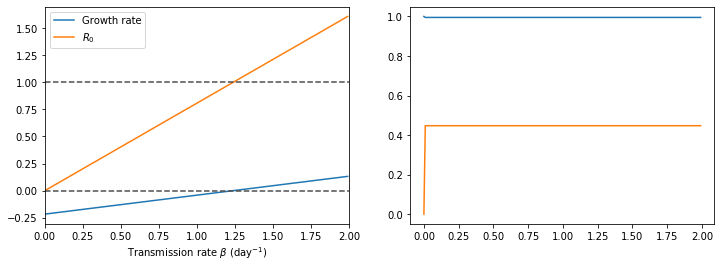

In [121]:
A = 0.5
N1 = 5.0/6.0
gamma = 1/10
sigma = 1/2
t1 = 0.1
a = (1-A)*sigma + A*gamma
N = 200
eig = np.zeros(N)
evec = np.zeros((N,2))
Reig = np.zeros(N)
Revec = np.zeros((N,2))
i = 0
for nu in np.arange(N)*0.01:
    eh, evech = eigenvalues(nu,a,t1,N1)
    eig[i] = np.max(eh)
    evec[i,:] = evech[np.argsort(eh)[0]]
    Reh, Revech = Reigenvalues(nu,a,t1,N1)
    Reig[i] = np.max(Reh)
    Revec[i,:] = evech[np.argsort(Reh)[0]]
    i += 1
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(np.arange(N)*0.01,eig,label='Growth rate')
ax[0].plot(np.arange(N)*0.01,Reig,label='$R_0$')
ax[0].set_xlabel('Transmission rate $\\beta$ (day$^{-1}$)')
ax[0].legend()
ax[0].plot([0,2],[0,0],'--',c=[0.3,0.3,0.3])
ax[0].plot([0,2],[1,1],'--',c=[0.3,0.3,0.3])
ax[0].set_xlim((0,2))
ax[1].plot(np.arange(N)*0.01,np.abs(evec[:,0]))
ax[1].plot(np.arange(N)*0.01,np.abs(evec[:,1]))

In [127]:
Nt = 100
N1 = 5/6
nu = 5
gamma = 1/10
sigma = 1/3
t1 = 0.1
a = (1-A)*sigma + A*gamma

In [128]:
S,I,R = SIRsim(nu,a,t1,N1)

Text(0.5, 0, 'Time (days)')

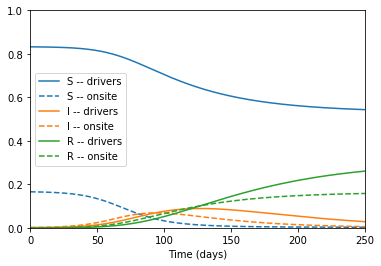

In [132]:
plt.plot(np.transpose(S)[:,0],color='C0',label='S -- drivers')
plt.plot(np.transpose(S)[:,1],'--',color='C0',label='S -- onsite')
plt.plot(np.transpose(I)[:,0],color='C1',label='I -- drivers')
plt.plot(np.transpose(I)[:,1],'--',color='C1',label='I -- onsite')
plt.plot(np.transpose(R)[:,0],color='C2',label='R -- drivers')
plt.plot(np.transpose(R)[:,1],'--',color='C2',label='R -- onsite')
plt.legend()
plt.xlim((0,250))
plt.ylim((0,1))
plt.xlabel('Time (days)')

Fairly high infection rate required: >1 infections per day for on-site staff if I've interpreted the units correctly

B/C we have assumed that drivers only come into contact at the depot, driver R << 1. Therefore depletion of onsite susceptibles stops the epidemic

This would be different if we take into account interactions outside the workplace, particularly if drivers are largely from same community.